# 라이브러리

In [ ]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt 

# GPU 설정

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 데이터 불러오기

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# VGG 16

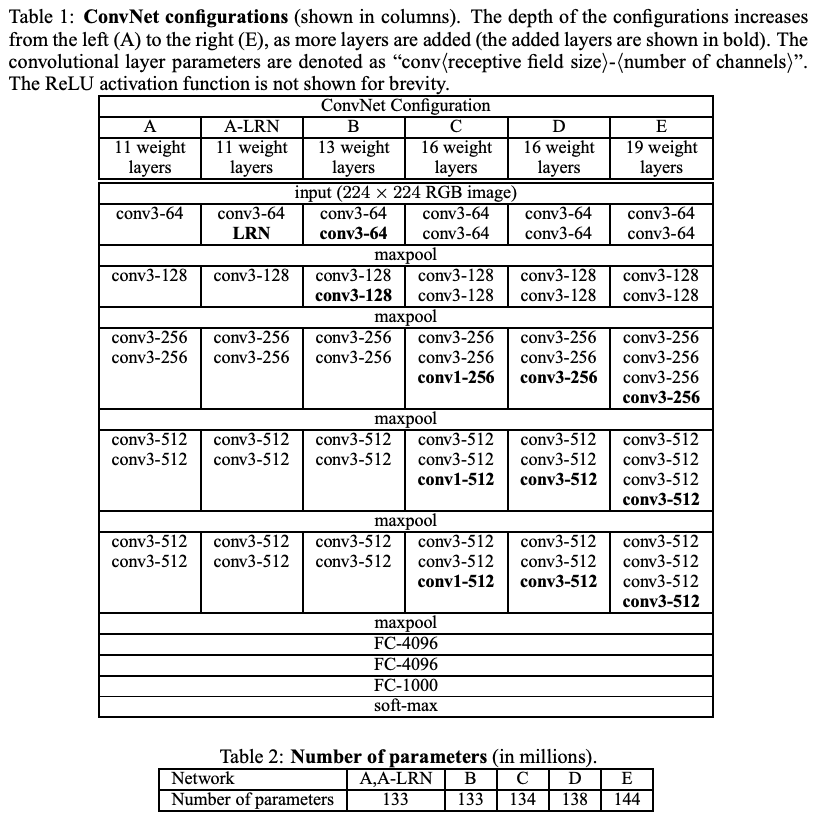

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
              nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.MaxPool2d(2,2)
          )
        
        self.layer2 = nn.Sequential(
              nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.MaxPool2d(2,2)
          )
        
        self.layer3 = nn.Sequential(
              nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.MaxPool2d(2,2)
          )

        self.layer4 = nn.Sequential(
              nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1),
              nn.ReLU(),
              nn.MaxPool2d(2,2)
          )

        self.fc_layer = nn.Sequential(
              nn.Linear(512, 4096),
              nn.ReLU(True),
              nn.Dropout(),
              nn.Linear(4096, 1000),
              nn.ReLU(True),
              nn.Dropout(),
              nn.Linear(1000, num_classes),
          )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = self.fc_layer(x)
        return x

In [ ]:
# VGG 16 모델 정의
model = VGG16(10).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


In [ ]:
loss_list = []

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    loss_list.append(avg_cost.cpu().detach().numpy())
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.02334535
[Epoch:    2] cost = 0.10241399
[Epoch:    3] cost = 0.0710810497
[Epoch:    4] cost = 0.0569273494
[Epoch:    5] cost = 0.0470098257
[Epoch:    6] cost = 0.0445733666
[Epoch:    7] cost = 0.0404559709
[Epoch:    8] cost = 0.0397707671
[Epoch:    9] cost = 0.035547588
[Epoch:   10] cost = 0.0322626419
[Epoch:   11] cost = 0.0305473432
[Epoch:   12] cost = 0.0258725751
[Epoch:   13] cost = 0.0300346017
[Epoch:   14] cost = 0.0216222927
[Epoch:   15] cost = 0.0218421798


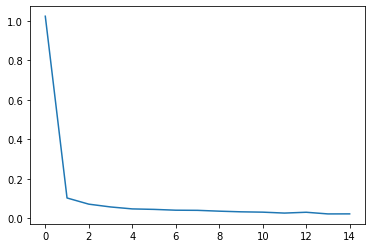

In [ ]:
plt.plot(loss_list)
plt.show()

In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9860000014305115
